# **2.3 Complex Machine Learning Models & Keras Part 2**

# **Predicting Pleasant Weather with Random Forests**

This project uses a random forest model to identify which weather variables and stations best predict a “pleasant day.” Drawing on decades of ClimateWins data, the aim is to pinpoint the most valuable predictors to improve their climate forecasts and guide investments.

## Table of Contents  
- [1. Import Libraries](#1-import-libraries)  
- [2. Load Data](#2-load-data)
- [3. Filter for One Decade](#3-filter-for-one-decade)  
- [4. Data Cleaning](#4-data-cleaning)  
- [5. Exploratory Data Analysis (EDA)](#5-exploratory-data-analysis-eda)  
- [6. Feature Engineering](#6-feature-engineering)  
- [7. Train/Test Split](#7-train/test-split)  
- [8. Model Building](#8-model-building)  
- [9. Model Evaluation](#9-model-evaluation)  
- [10. Identify Top 3 Stations](#10-identify-top-3-stations)  
- [11. Build Random Forests per Station](#11-build-random-forests-per-station)
- [12. Conclusion](#12-conclusion)    

---

## 1. Import Libraries

Here's where I load the Python packages I’ll need:

- `pandas` and `numpy` for data handling
- `matplotlib` and `seaborn` for visuals
- `sklearn` for building and evaluating the random forest model

These are the standard go-to tools for most machine learning projects, especially when working with structured tabular data like this.

In [1]:
# Import libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import plot_tree

---

## 2. Load Data

I’m loading in the cleaned weather observations (`X`) and the target column for whether the day was considered “pleasant” or not (`y`).  
Just checking the shapes and and the first few rows to make sure everything came in clean and looks right.

In [2]:
# Create a path to where my data is stored
path = r'/Users/yaseminmustafa/Desktop/CareerFoundry/Specialisation'

In [3]:
# Load the data
X = pd.read_csv(os.path.join(path, 'Achievement 2', '2.2', 'weather_cleaned.csv'))
y = pd.read_csv(os.path.join(path, 'Achievement 1', '1.4', 'pleasant_weather_answers.csv'))

In [4]:
# Check shape and preview data
print("X shape:", X.shape)
print("y shape:", y.shape)

display(X.head())
display(y.head())

X shape: (22950, 135)
y shape: (22950, 16)


,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BELGRADE_cloud_cover,...,VALENTIA_pressure,VALENTIA_global_radiation,VALENTIA_precipitation,VALENTIA_sunshine,VALENTIA_temp_mean,VALENTIA_temp_min,VALENTIA_temp_max,KASSEL_cloud_cover,MUNCHENB_pressure,STOCKHOLM_humidity
0,7,0.85,1.018,0.32,0.09,0.7,6.5,0.8,10.9,1,...,1.0003,0.45,0.34,4.7,8.5,6.0,10.9,8,1.0304,0.98
1,6,0.84,1.018,0.36,1.05,1.1,6.1,3.3,10.1,6,...,1.0007,0.25,0.84,0.7,8.9,5.6,12.1,6,1.0292,0.62
2,8,0.90,1.018,0.18,0.30,0.0,8.5,5.1,9.9,6,...,1.0096,0.17,0.08,0.1,10.5,8.1,12.9,8,1.0320,0.69
3,3,0.92,1.018,0.58,0.00,4.1,6.3,3.8,10.6,8,...,1.0184,0.13,0.98,0.0,7.4,7.3,10.6,6,1.0443,0.98
4,6,0.95,1.018,0.65,0.14,5.4,3.0,-0.7,6.0,8,...,1.0328,0.46,0.00,5.7,5.7,3.0,8.4,7,1.0430,0.96


,DATE,BASEL_pleasant_weather,BELGRADE_pleasant_weather,BUDAPEST_pleasant_weather,DEBILT_pleasant_weather,DUSSELDORF_pleasant_weather,HEATHROW_pleasant_weather,KASSEL_pleasant_weather,LJUBLJANA_pleasant_weather,MAASTRICHT_pleasant_weather,MADRID_pleasant_weather,MUNCHENB_pleasant_weather,OSLO_pleasant_weather,SONNBLICK_pleasant_weather,STOCKHOLM_pleasant_weather,VALENTIA_pleasant_weather
0,19600101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,19600102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,19600103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,19600104,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,19600105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


---

## 3. Filter for One Decade

In the previous exercise, I dropped the DATE column from the dataset to simplify the features, since the random forest model doesn’t require explicit date information. However, because the data was already ordered chronologically, I can still approximate a single decade by taking the first 3,653 rows of the dataset. This matches the assignment hint for one decade (X = (3653, 135) and y = (3653)). Selecting this subset ensures the model trains on a consistent time period without needing the date column, which keeps the workflow straightforward while meeting the assignment requirements.

In [5]:
# Take first 3653 rows (approx. one decade)
X = X.iloc[:3653, :]
y = y.iloc[:3653, :]

# Check shapes
print("Shapes after selecting one decade:")
print("X shape:", X.shape)
print("y shape:", y.shape)

Shapes after selecting one decade:
X shape: (3653, 135)
y shape: (3653, 16)


---

## 4. Data Cleaning

The dataset had already undergone initial cleaning; however, I will perform a quick check for any missing values or duplicate rows to ensure data integrity. I will also review the column names to confirm there are no unusual characters or extra spaces that might cause issues during processing. Additionally, since the date column is present in the y DataFrame and is not required for modelling, I will remove it.

In [6]:
# Data Cleaning

# Check for missing values
print("Missing values in X:")
print(X.isnull().sum().sum())

print("\nMissing values in y:")
print(y.isnull().sum().sum())

# Check for duplicates
print("\nDuplicate rows in X:", X.duplicated().sum())
print("Duplicate rows in y:", y.duplicated().sum())

# Check column names
print("\nFirst 5 column names in X:")
print(X.columns[:5])

Missing values in X:
0

Missing values in y:
0

Duplicate rows in X: 0
Duplicate rows in y: 0

First 5 column names in X:
Index(['BASEL_cloud_cover', 'BASEL_humidity', 'BASEL_pressure',
       'BASEL_global_radiation', 'BASEL_precipitation'],
      dtype='object')


In [7]:
# Drop the 'date' column
y = y.drop(columns=['DATE'])

In [8]:
# Check shape and preview data
print("X shape:", X.shape)
print("y shape:", y.shape)

display(X.head())
display(y.head())

X shape: (3653, 135)
y shape: (3653, 15)


,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BELGRADE_cloud_cover,...,VALENTIA_pressure,VALENTIA_global_radiation,VALENTIA_precipitation,VALENTIA_sunshine,VALENTIA_temp_mean,VALENTIA_temp_min,VALENTIA_temp_max,KASSEL_cloud_cover,MUNCHENB_pressure,STOCKHOLM_humidity
0,7,0.85,1.018,0.32,0.09,0.7,6.5,0.8,10.9,1,...,1.0003,0.45,0.34,4.7,8.5,6.0,10.9,8,1.0304,0.98
1,6,0.84,1.018,0.36,1.05,1.1,6.1,3.3,10.1,6,...,1.0007,0.25,0.84,0.7,8.9,5.6,12.1,6,1.0292,0.62
2,8,0.90,1.018,0.18,0.30,0.0,8.5,5.1,9.9,6,...,1.0096,0.17,0.08,0.1,10.5,8.1,12.9,8,1.0320,0.69
3,3,0.92,1.018,0.58,0.00,4.1,6.3,3.8,10.6,8,...,1.0184,0.13,0.98,0.0,7.4,7.3,10.6,6,1.0443,0.98
4,6,0.95,1.018,0.65,0.14,5.4,3.0,-0.7,6.0,8,...,1.0328,0.46,0.00,5.7,5.7,3.0,8.4,7,1.0430,0.96


,BASEL_pleasant_weather,BELGRADE_pleasant_weather,BUDAPEST_pleasant_weather,DEBILT_pleasant_weather,DUSSELDORF_pleasant_weather,HEATHROW_pleasant_weather,KASSEL_pleasant_weather,LJUBLJANA_pleasant_weather,MAASTRICHT_pleasant_weather,MADRID_pleasant_weather,MUNCHENB_pleasant_weather,OSLO_pleasant_weather,SONNBLICK_pleasant_weather,STOCKHOLM_pleasant_weather,VALENTIA_pleasant_weather
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


---

## 5. Exploratory Data Analysis (EDA)

I will observe some simple statistics to understand the distribution and range of each feature, keeping an eye out for unusual values or potential outliers before moving into modelling.

In [9]:
# Exploratory Data Analysis (EDA)

# Descriptive stats
X.describe()

,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BELGRADE_cloud_cover,...,VALENTIA_pressure,VALENTIA_global_radiation,VALENTIA_precipitation,VALENTIA_sunshine,VALENTIA_temp_mean,VALENTIA_temp_min,VALENTIA_temp_max,KASSEL_cloud_cover,MUNCHENB_pressure,STOCKHOLM_humidity
count,3653.000000,3653.000000,3.653000e+03,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,...,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000
mean,5.356967,0.788034,1.018000e+00,1.364062,0.217649,4.469997,9.533041,5.392198,14.728798,4.324938,...,1.013531,1.220846,0.380057,3.652587,10.410183,7.538735,13.263345,5.322475,1.031011,0.758306
std,2.510030,0.106100,2.309580e-14,0.956842,0.470863,4.238786,7.531501,6.726691,9.057698,2.717701,...,0.012083,0.924152,0.620298,3.718844,3.754035,4.132335,3.837303,2.371456,0.007961,0.153799
min,0.000000,0.380000,1.018000e+00,0.170000,0.000000,0.000000,-16.200000,-21.500000,-10.100000,0.000000,...,0.968000,0.120000,0.000000,0.000000,-1.300000,-7.300000,1.100000,0.000000,1.001400,0.300000
25%,3.000000,0.710000,1.018000e+00,0.540000,0.000000,0.400000,3.900000,0.700000,7.600000,2.000000,...,1.005700,0.420000,0.000000,0.300000,7.900000,4.900000,10.700000,3.000000,1.026300,0.650000
50%,6.000000,0.800000,1.018000e+00,1.150000,0.000000,3.500000,10.200000,5.800000,15.400000,5.000000,...,1.014700,0.960000,0.100000,2.600000,10.500000,8.000000,13.200000,6.000000,1.031200,0.780000
75%,8.000000,0.870000,1.018000e+00,2.080000,0.220000,7.700000,15.500000,10.800000,21.800000,7.000000,...,1.022200,1.880000,0.500000,6.100000,13.500000,10.700000,16.300000,8.000000,1.036000,0.880000
max,8.000000,1.000000,1.018000e+00,3.600000,5.350000,14.800000,26.000000,19.900000,36.100000,8.000000,...,1.046300,3.980000,5.590000,15.700000,20.600000,16.700000,25.100000,8.000000,1.058500,1.000000


----

## 6. Feature Engineering

Since y contains 15 columns — one for each city’s “pleasant day” label — it represents a multi-output target. Random Forests in scikit-learn can handle multi-output classification directly, so I don’t need to flatten y; keeping it as a 2D array preserves the structure of one target per city. Flattening would collapse all columns into a single vector, which would lose the city-specific labels and make modelling incorrect.

----

## 7. Train/Test Split

Dividing the dataset into an 80/20 split allows the model to learn from the training portion and be evaluated on unseen test data. Using random_state=42 ensures the split is reproducible each time the code runs.

In [10]:
# Check input shapes
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Perform the 80/20 split (no stratify for multi-output)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 20% for testing
    random_state=42       # reproducible split
)

# Confirm split sizes
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Features shape: (3653, 135)
Target shape: (3653, 15)
Training set: (2922, 135), (2922, 15)
Test set: (731, 135), (731, 15)


Because y has multiple columns (one per city), we don’t use stratify, and random_state=42 ensures the split is consistent each time. The shapes confirm the split worked as expected.

----

## 8. Model Building

I initialise and train a Random Forest Classifier to predict whether a given day will be pleasant based on historical weather data. The model is set to use 100 decision trees (n_estimators=100) for robust and reliable predictions, with a fixed random_state to ensure reproducibility. Training the model on the decade-long dataset (X_train, y_train) allows it to learn the relationships between multiple weather indicators and the pleasantness of a day, preparing it for subsequent evaluation and visualisation of individual decision trees.

In [11]:
# Initialise the random forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

----

## 9. Model Evaluation

I will begin by evaluating the model’s performance on both the training and test sets. A large gap between the two — with high training accuracy but much lower test accuracy — would suggest overfitting, meaning the model memorised the training data rather than learning general patterns. On the other hand, similar scores would indicate the model is generalising well to unseen data.

In [12]:
# Predict on training and test sets
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculate accuracy (averaged over all outputs)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print results
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 1.0000
Test Accuracy: 0.6019


*The model achieved 100% accuracy on the training set, but the test accuracy dropped to about 60.2%. This large gap indicates the model is overfitting — it’s memorising the training data rather than generalising well to unseen data. There’s clearly room to improve performance on the test set, for example by tuning hyperparameters.*

### 9.1 Feature Importance

Random forests provide built-in feature importance scores, which makes it easy to see which weather variables have the biggest impact on predicting pleasant days. In this step, I’m identifying the top 15 features (weather stations), ranking them from the most influential to the least, to understand which factors the model relies on most.

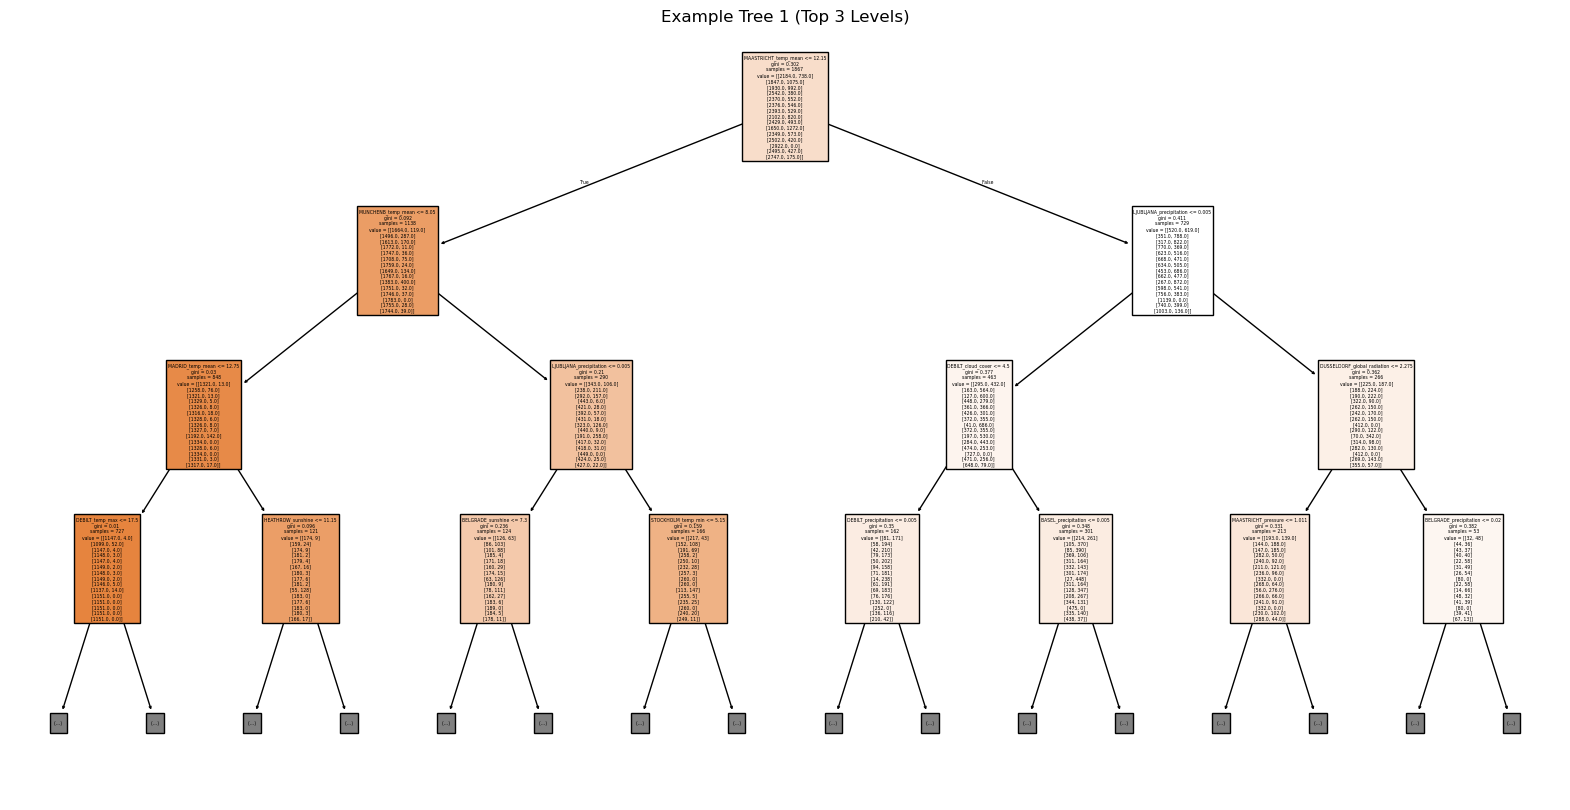

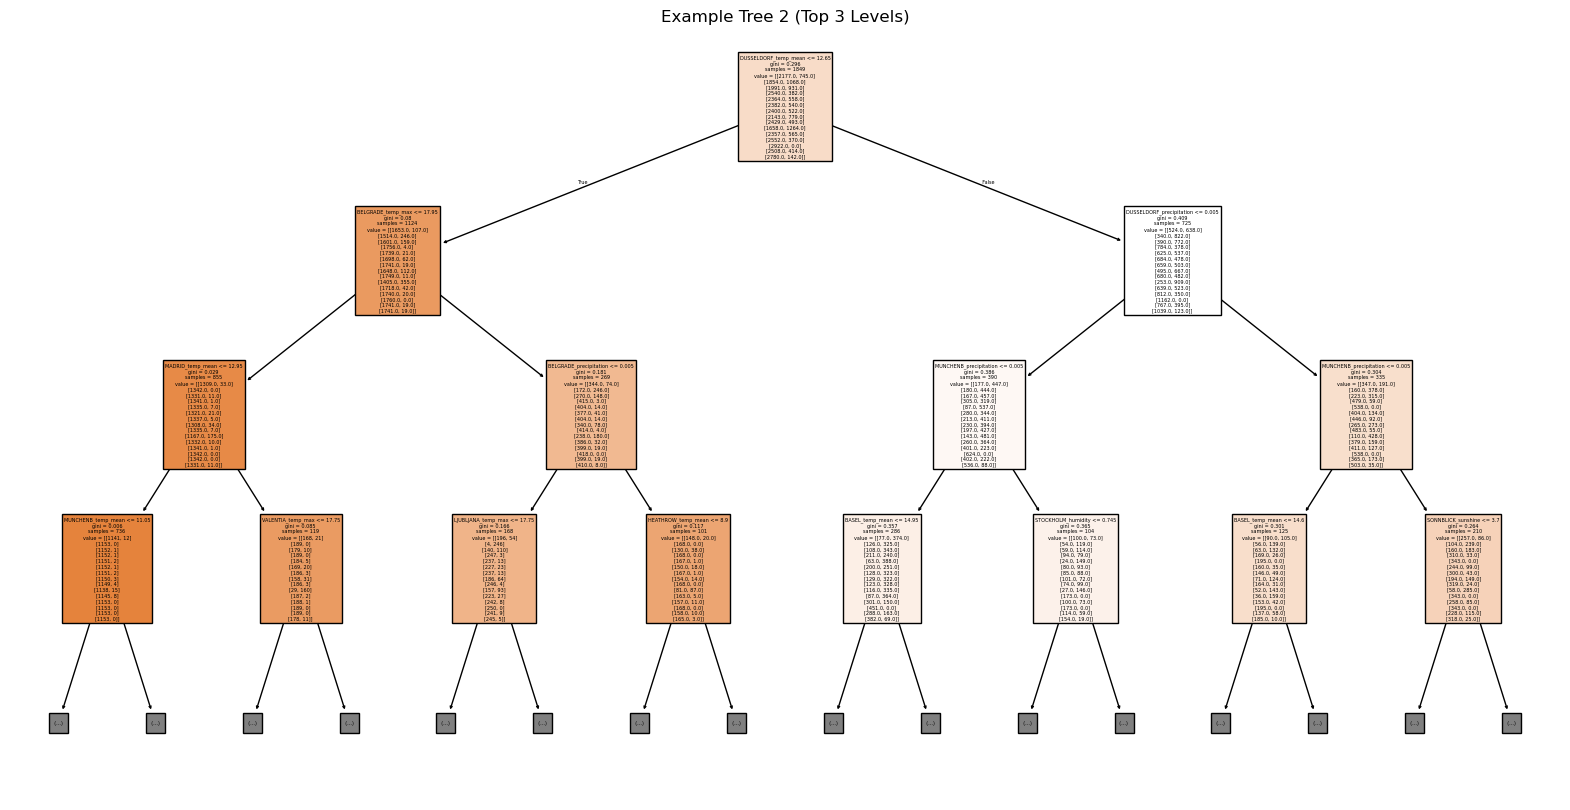

In [13]:
# Plot two example trees
plt.figure(figsize=(20,10))
plot_tree(rf_model.estimators_[0], feature_names=X.columns, filled=True, max_depth=3)
plt.title("Example Tree 1 (Top 3 Levels)")
plt.show()

plt.figure(figsize=(20,10))
plot_tree(rf_model.estimators_[1], feature_names=X.columns, filled=True, max_depth=3)
plt.title("Example Tree 2 (Top 3 Levels)")
plt.show()

In [14]:
# Feature importance extraction
# rf_model.feature_importances_ gives importance for each feature
importances = rf_model.feature_importances_
print(f"Raw importances shape: {importances.shape}")  # Should match X columns

# These features are organised by station and type (e.g. 15 stations × 9 features)
# Reshape to (15,9) for summing per station
important_reshaped = importances.reshape(15, 9)

# Sum across feature types to get one importance value per station
station_importance = np.sum(important_reshaped, axis=1)
print("Station importances:", station_importance)

Raw importances shape: (135,)
Station importances: [0.09364018 0.0606278  0.06073228 0.06645056 0.10667323 0.06004928
 0.07087193 0.06645656 0.09587871 0.0671565  0.07525685 0.05668645
 0.03423596 0.05121135 0.03407237]


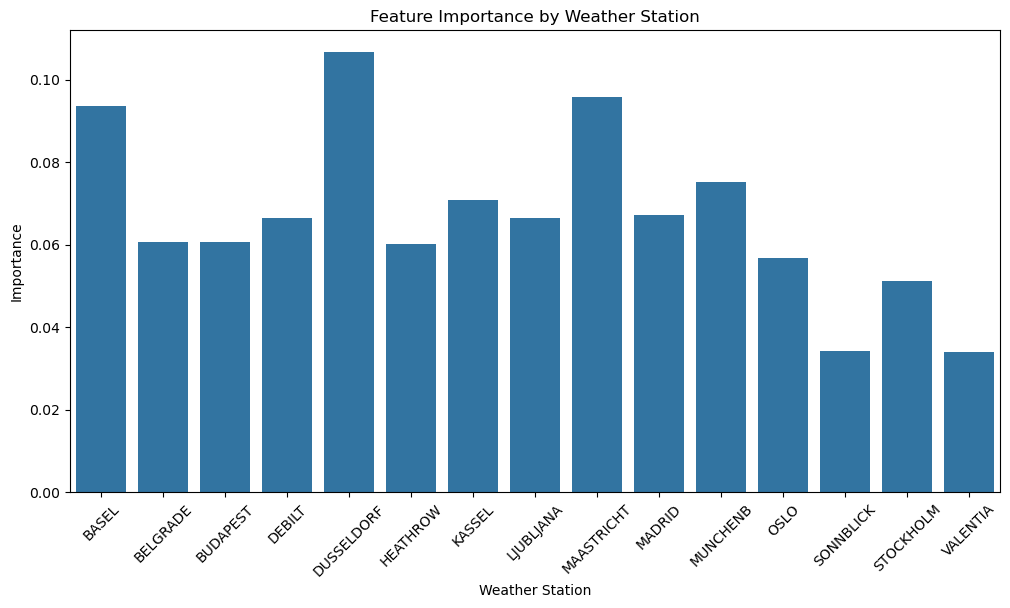

In [15]:
# Plot bar chart of station importances
stations = [col.split('_')[0] for col in y.columns]  # Get station names from y columns
plt.figure(figsize=(12,6))
sns.barplot(x=stations, y=station_importance)
plt.ylabel("Importance")
plt.xlabel("Weather Station")
plt.title("Feature Importance by Weather Station")
plt.xticks(rotation=45)
plt.show()

----

## 10. Identify Top 3 Stations

I am identifying the top three weather stations by summing the feature importances from the Random Forest model and selecting the highest values. Focusing on these stations allows us to build targeted models and understand which locations contribute most to predicting pleasant weather.

In [16]:
# Get indices of top 3 stations by importance
top3_indices = np.argsort(station_importance)[-3:][::-1]
top3_stations = [stations[i] for i in top3_indices]
print("Top 3 stations:", top3_stations)

Top 3 stations: ['DUSSELDORF', 'MAASTRICHT', 'BASEL']


----

## 11. Build Random Forests per Station

I am building a separate Random Forest model for each of the top three stations identified earlier based on their overall importance. Using the full dataset (all years), I subset the features and target variables for each station individually, split them into training and test sets, and fit a model. This allows me to evaluate the predictive accuracy for each station, visualise one of the decision trees in the forest, and determine which observations (features) are most influential for predictions. By focusing on each station separately, I can better understand the specific factors driving pleasant weather outcomes at different locations.

In [17]:
# Subset full dataset for each top station 
# Make sure we are using the full dataset (not just the first decade)
X_full = pd.read_csv(os.path.join(path, 'Achievement 2', '2.2', 'weather_cleaned.csv'))
y_full = pd.read_csv(os.path.join(path, 'Achievement 1', '1.4', 'pleasant_weather_answers.csv'))

In [18]:
# Check shape and preview data
print("X shape:", X.shape)
print("y shape:", y.shape)

display(X.head())
display(y.head())

X shape: (3653, 135)
y shape: (3653, 15)


,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BELGRADE_cloud_cover,...,VALENTIA_pressure,VALENTIA_global_radiation,VALENTIA_precipitation,VALENTIA_sunshine,VALENTIA_temp_mean,VALENTIA_temp_min,VALENTIA_temp_max,KASSEL_cloud_cover,MUNCHENB_pressure,STOCKHOLM_humidity
0,7,0.85,1.018,0.32,0.09,0.7,6.5,0.8,10.9,1,...,1.0003,0.45,0.34,4.7,8.5,6.0,10.9,8,1.0304,0.98
1,6,0.84,1.018,0.36,1.05,1.1,6.1,3.3,10.1,6,...,1.0007,0.25,0.84,0.7,8.9,5.6,12.1,6,1.0292,0.62
2,8,0.90,1.018,0.18,0.30,0.0,8.5,5.1,9.9,6,...,1.0096,0.17,0.08,0.1,10.5,8.1,12.9,8,1.0320,0.69
3,3,0.92,1.018,0.58,0.00,4.1,6.3,3.8,10.6,8,...,1.0184,0.13,0.98,0.0,7.4,7.3,10.6,6,1.0443,0.98
4,6,0.95,1.018,0.65,0.14,5.4,3.0,-0.7,6.0,8,...,1.0328,0.46,0.00,5.7,5.7,3.0,8.4,7,1.0430,0.96


,BASEL_pleasant_weather,BELGRADE_pleasant_weather,BUDAPEST_pleasant_weather,DEBILT_pleasant_weather,DUSSELDORF_pleasant_weather,HEATHROW_pleasant_weather,KASSEL_pleasant_weather,LJUBLJANA_pleasant_weather,MAASTRICHT_pleasant_weather,MADRID_pleasant_weather,MUNCHENB_pleasant_weather,OSLO_pleasant_weather,SONNBLICK_pleasant_weather,STOCKHOLM_pleasant_weather,VALENTIA_pleasant_weather
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
# Dictionary to store feature names (observations) per station
station_features_dict = {}

In [20]:
print("Top 3 stations list:", top3_stations)

Top 3 stations list: ['DUSSELDORF', 'MAASTRICHT', 'BASEL']



Processing full dataset for station: DUSSELDORF
DUSSELDORF - X shape: (22950, 9)
DUSSELDORF - y shape: (22950, 1)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


DUSSELDORF - Training Accuracy: 1.0000
DUSSELDORF - Test Accuracy: 1.0000


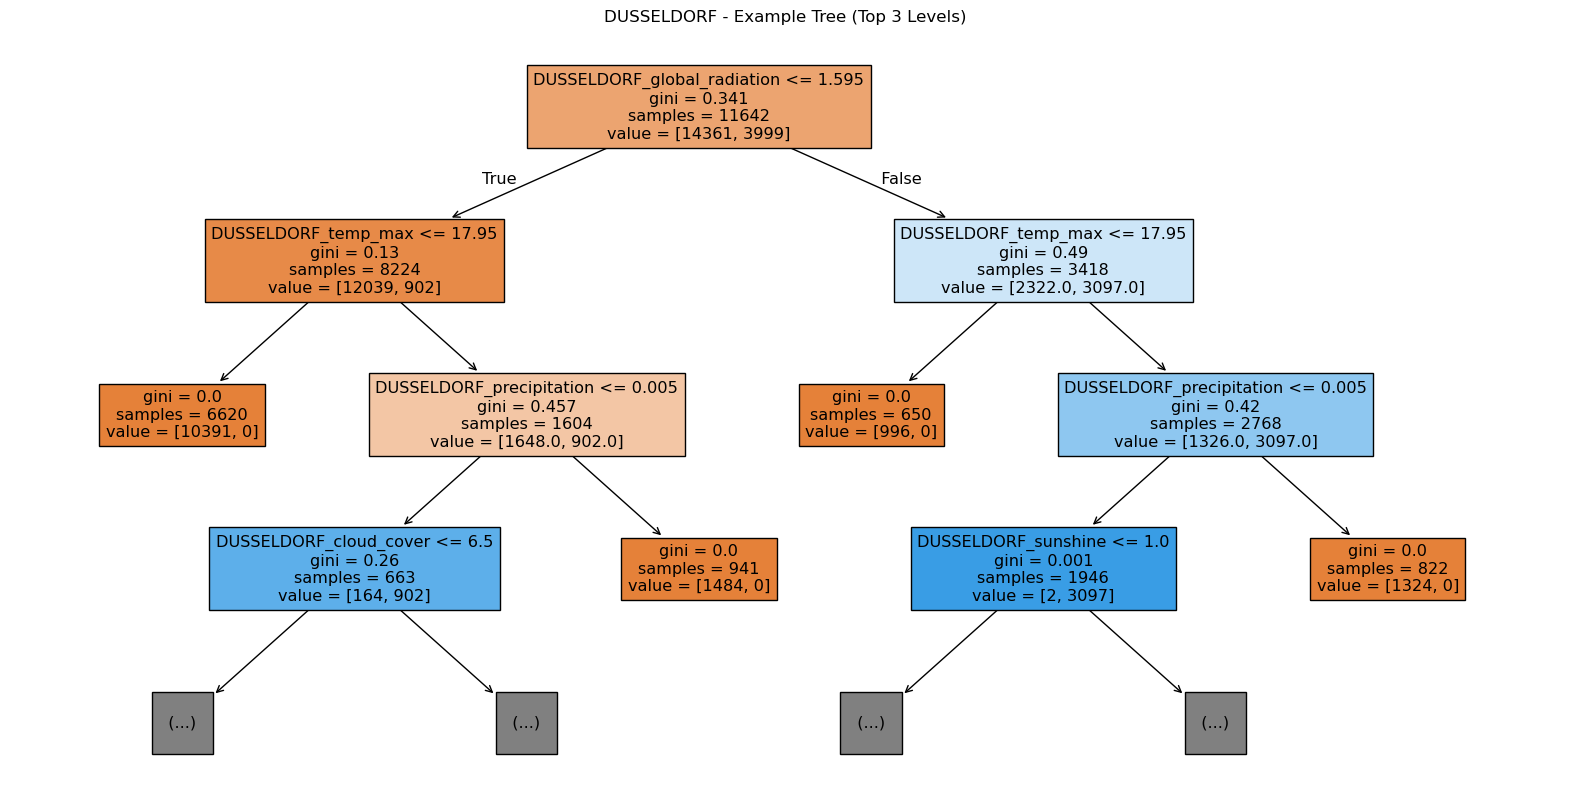

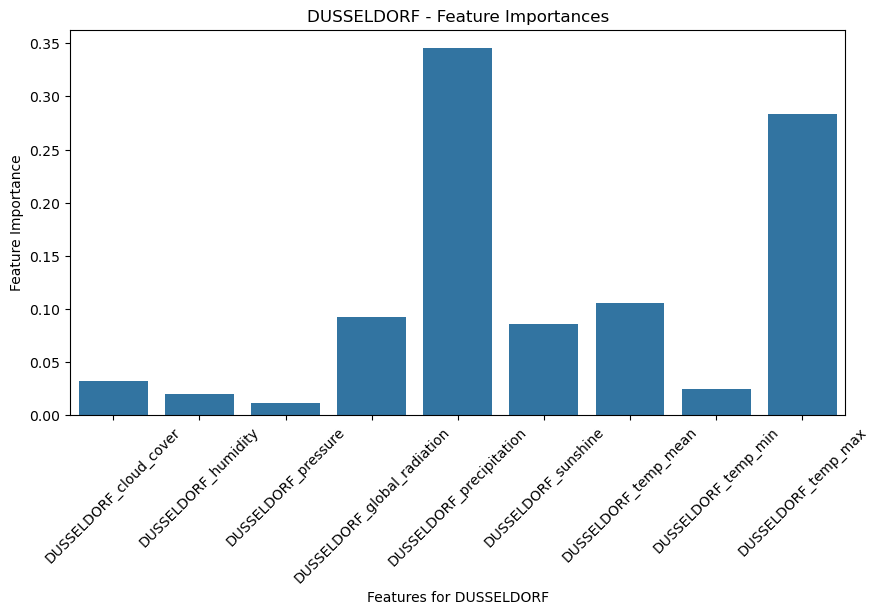


Processing full dataset for station: MAASTRICHT
MAASTRICHT - X shape: (22950, 9)
MAASTRICHT - y shape: (22950, 1)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


MAASTRICHT - Training Accuracy: 1.0000
MAASTRICHT - Test Accuracy: 1.0000


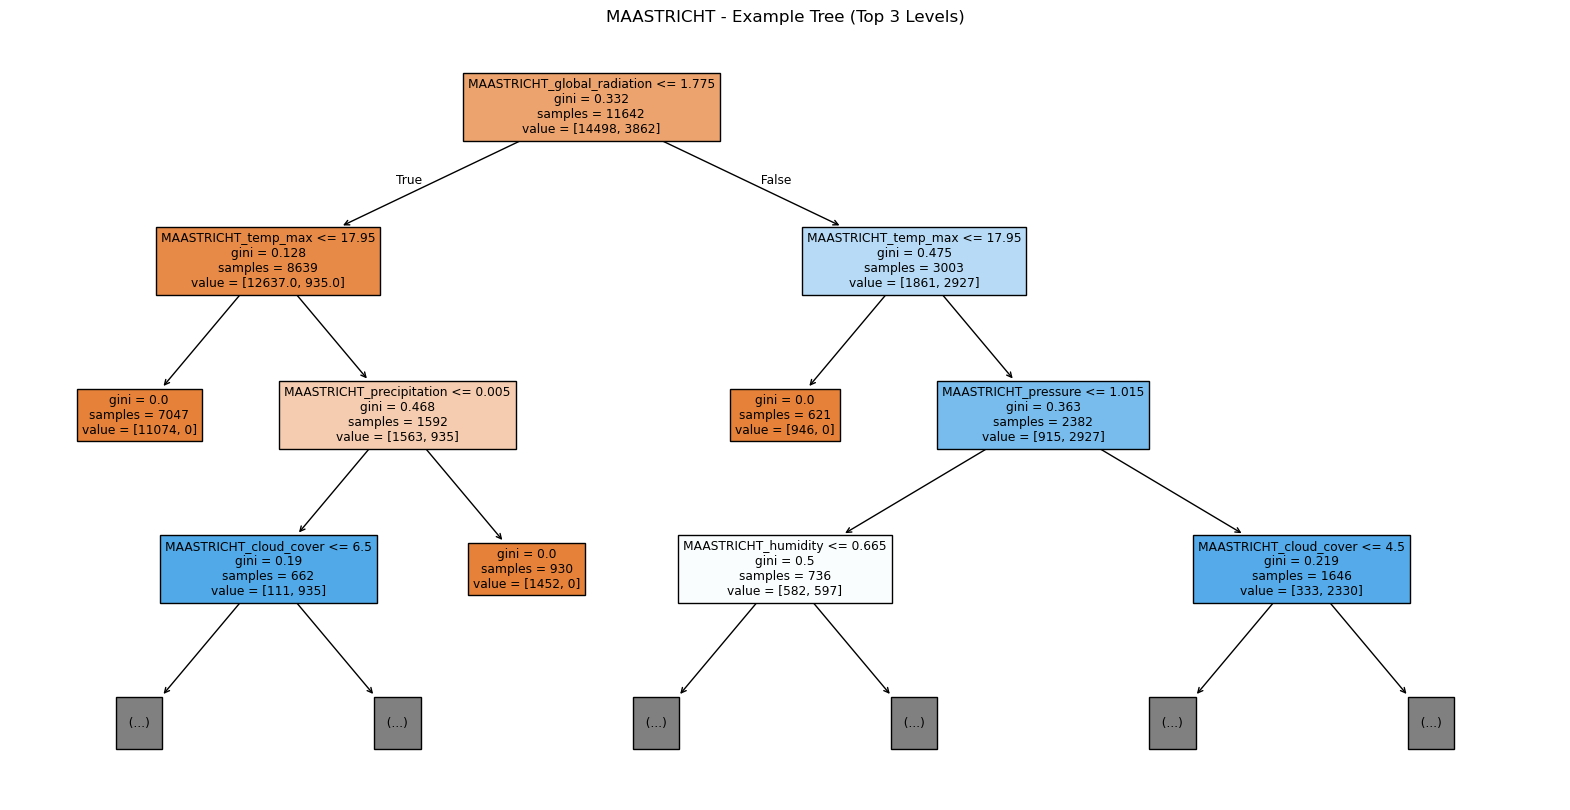

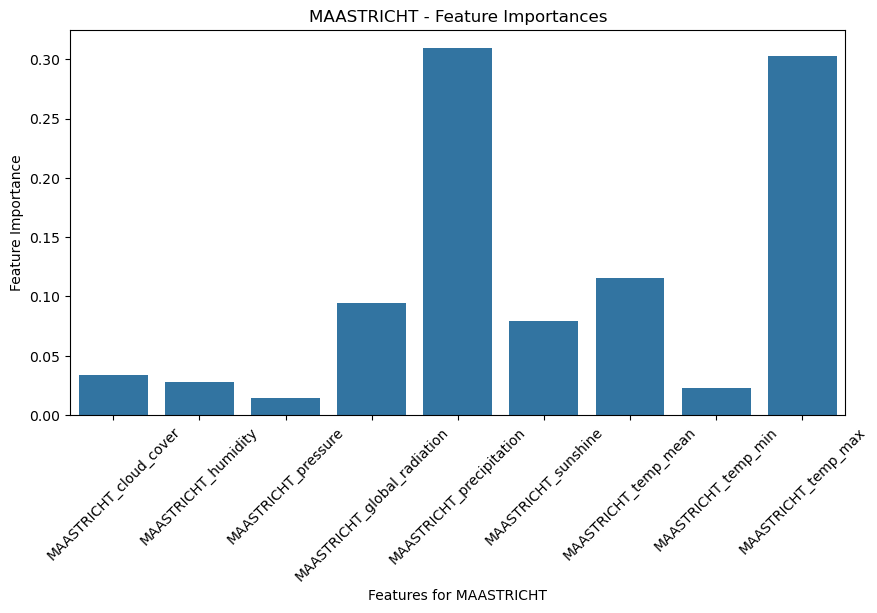


Processing full dataset for station: BASEL
BASEL - X shape: (22950, 9)
BASEL - y shape: (22950, 1)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


BASEL - Training Accuracy: 1.0000
BASEL - Test Accuracy: 1.0000


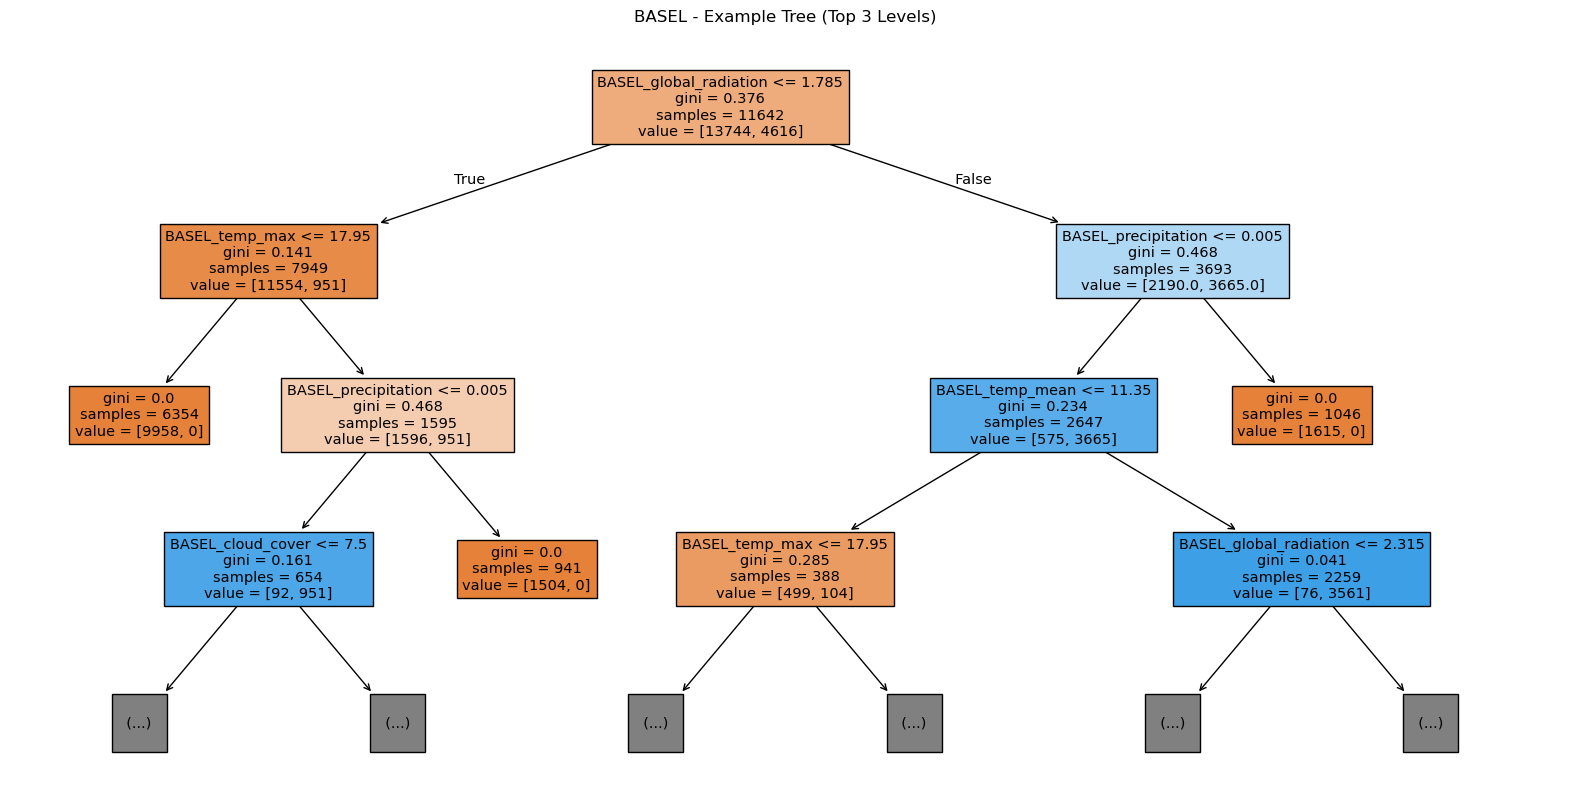

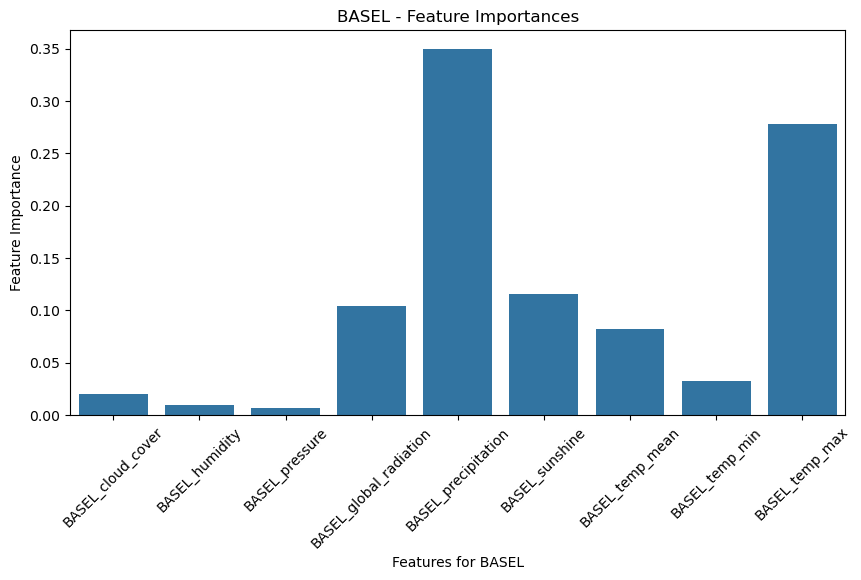

In [21]:
# Loop through the top 3 stations
for station in top3_stations:
    print(f"\nProcessing full dataset for station: {station}")
    
    # Select features for this station only
    station_features = [col for col in X_full.columns if col.startswith(station)]
    X_station_full = X_full[station_features]
    
    # Select the corresponding target column
    y_col = [col for col in y_full.columns if station in col][0]
    y_station_full = y_full[[y_col]]
    
    # ----- Check shapes -----
    print(f"{station} - X shape: {X_station_full.shape}")
    print(f"{station} - y shape: {y_station_full.shape}")

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_station_full, y_station_full, test_size=0.2, random_state=42
    )

    # Initialize and train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)

    # Predict and calculate accuracy
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    print(f"{station} - Training Accuracy: {train_acc:.4f}")
    print(f"{station} - Test Accuracy: {test_acc:.4f}")

    # Plot one example tree
    plt.figure(figsize=(20,10))
    plot_tree(rf.estimators_[0], feature_names=X_station_full.columns,
              filled=True, max_depth=3)
    plt.title(f"{station} - Example Tree (Top 3 Levels)")
    plt.show()

    # Feature importance plot 
    importance = rf.feature_importances_
    plt.figure(figsize=(10,5))
    sns.barplot(x=X_station_full.columns, y=importance)
    plt.xticks(rotation=45)
    plt.ylabel("Feature Importance")
    plt.xlabel(f"Features for {station}")
    plt.title(f"{station} - Feature Importances")
    plt.show()

*The Random Forest models for Düsseldorf, Maastricht, and Basel achieved perfect accuracy on both the training and test sets (100% and 100%). This means the models correctly classified all observations in both datasets. While such results suggest the models captured the relationships in the data extremely well, perfect scores in both sets are unusual and may indicate overfitting, especially in real-world predictive tasks like weather forecasting. Further validation on truly unseen data would be needed to confirm whether these results reflect genuine predictive power or memorisation of the dataset.*

----

## 12. Conclusion

In this analysis, I examined the top three weather stations identified by my model and evaluated which climate indicators most strongly influence the likelihood of a day being classified as pleasant. By comparing feature importance values from station-specific random forest models, I identified recurring patterns across different locations. These findings provide evidence-based guidance for ClimateWins on which variables to prioritise when predicting pleasant weather or allocating resources for new climate-tracking equipment.

*Across all three top stations — Düsseldorf, Maastricht, and Basel — global precipitation emerged as the most important indicator for predicting whether a day will be pleasant, with feature importance values between 0.32 and 0.35. For Maastricht and Basel, maximum temperature followed closely (around 0.30), suggesting that temperature extremes also strongly influence pleasant-weather predictions. Other consistently important indicators included mean temperature, global radiation, and sunshine duration, though their rankings varied slightly by station. The repeated dominance of precipitation and temperature measures across geographically different locations suggests these variables should be prioritised for future climate-tracking investments. Enhancing the resolution and accuracy of these sensors may yield the greatest improvements in forecasting pleasant weather events.*